In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import orbipy as op

In [2]:
model = op.crtbp3_model('Earth-Moon (default)')
plotter = op.plotter.from_model(model, length_units='Mm')
scaler = op.scaler.from_model(model)

In [3]:
def NextDxNewton(dx, y0, y1, dxmax, tol):
    NewDx = 0
    if abs(y1)>=tol and y0 != y1:
        NewDx = dx
        if y1 != 0:  
            NewDx = max(min(dx * y1/(y0-y1),dxmax),-dxmax)

    return NewDx

class optimizer:
    dx = 0.001
    dxmax = 0.1
    xvals = []
    yvals = []
    step = 0
    tolerance = 0.000001

    def __init__(self):
        self.xvals = []
        self.yvals = []
        self.step = 0
        
    def needNextStep(self):
        if len(self.yvals) <= 2: return True
        if abs(self.xvals[0]-self.xvals[1]) <= self.tolerance:
            return False
        else:
            return True
            
            
    def nextX(self, x, y):
        self.step+=1;
        
        i = 0
        #находим место для добавления точки, чтобы массив остался отсортированным
        while i < min(2, len(self.yvals)) and y > self.yvals[i]: i+=1
        self.xvals.insert(i,x)
        self.yvals.insert(i,y)

        xvals = self.xvals
        yvals = self.yvals
        
        if self.step == 1:
            return x+self.dx

        x1 = xvals[0]+NextDxNewton(xvals[1]-xvals[0], yvals[0], yvals[1], self.dx, 0)
        if self.step > 2:
            #print(xvals, yvals)
            a = yvals[0]/(xvals[0]-xvals[1])/(xvals[0]-xvals[2]) - yvals[1]/(xvals[0]-xvals[1])/(xvals[1]-xvals[2]) + yvals[2]/(xvals[1]-xvals[2])/(xvals[0]-xvals[2])
            #print(a)
            if a > 0:
                b = (yvals[0]-yvals[1])/(xvals[0]-xvals[1]) - a*(xvals[0]+xvals[1])
                xm = -b/2/a
                x1 = x + max(min(xm-x, self.dxmax), -self.dxmax)
        
        return x1

    def getXY(self):
        return (self.xvals[0], self.yvals[0])


In [4]:
halo = pd.read_csv("halo_general_upper.csv")

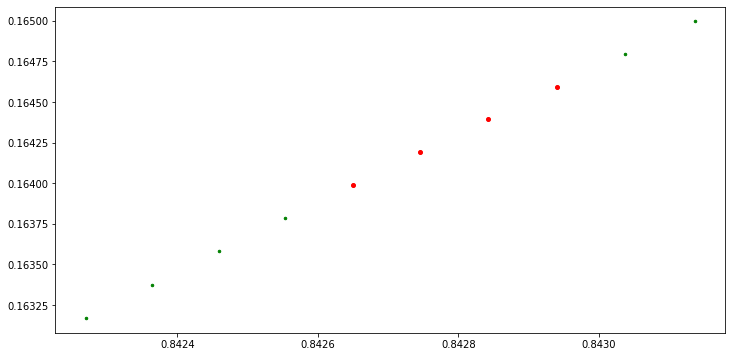

In [5]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(halo.x[650:660], halo.z[650:660], '.g', ms=5)
ax.plot(halo.x[652:656], halo.z[652:656], '.r', ms=8)

# First step

In [7]:
x, z, v = halo.iloc[655, :3]
radius = 100 / model.R
dalpha = np.pi / 180 

In [10]:
values = []
arrs = []

0 [0.84290976 0.         0.16398797 0.         0.26354836 0.        ]
0 9.999999999998899e-05 j 9 dist 7.700926086567686e-08
1 1.4302342088434727e-09 j 149 dist 8.408336183121104e-06
2 1.5695272859161946e-10 j 14 dist 1.4652718793320404e-06
3 4.7124526503239395e-12 j 10 dist 2.843880159555808e-09
4 2.1765922397776194e-13 j 9 dist 6.588241467823897e-07
5 4.959366251000574e-13 j 8 dist 1.5794942950328295e-05
v 0.2582943007136588
Distance 4.5183611945029715e-05
vx 0.0001254735597901284


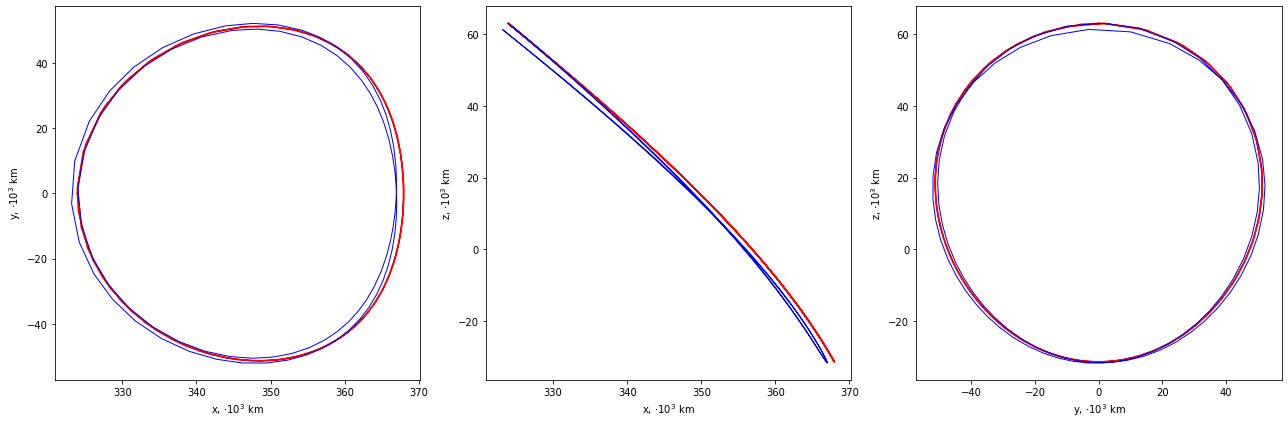

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')

beg = 0

for k in range(beg, beg + 1):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2
            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()   
        print(i, abs(v1 - cur[4]), 'j', j, 'dist', dist)
        cur[4] = v1
        
    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    distance = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    vx = ev1.iloc[-1, 7]
    values.append((k, x1, z1, v1, distance, vx))
    arrs.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr_ref, ax=ax, colors='r');
    plotter.plot_proj(arr1, ax=ax, lw=1);

181 [0.84238951 0.         0.16398343 0.         0.26354836 0.        ]
v 0.2712004920401405
Distance 8.973409403005603e-05
vx 8.199508271623974e-05

182 [0.84238962 0.         0.16397889 0.         0.26354836 0.        ]
v 0.27108470610973834
Distance 8.610965815545766e-05
vx 7.64608387375707e-05

183 [0.84238982 0.         0.16397436 0.         0.26354836 0.        ]
v 0.2709680045393673
Distance 8.26596743393806e-05
vx 7.106163594916559e-05

184 [0.8423901  0.         0.16396983 0.         0.26354836 0.        ]
v 0.2708504553732873
Distance 7.93846602263574e-05
vx 6.580229352188063e-05

185 [0.84239046 0.         0.1639653  0.         0.26354836 0.        ]
v 0.2707321221134183
Distance 7.628401260922911e-05
vx 6.0686816714915215e-05

186 [0.84239089 0.         0.16396078 0.         0.26354836 0.        ]
v 0.27061306414779335
Distance 7.335590885659811e-05
vx 5.5718945887583277e-05

187 [0.8423914  0.         0.16395627 0.         0.26354836 0.        ]
v 0.27049333711207596
Dista

v 0.2646055138712888
Distance 8.315320189819266e-06
vx -1.1669642737504454e-05

236 [0.84250414 0.         0.1637723  0.         0.26354836 0.        ]
v 0.2644890874858566
Distance 7.147092842860275e-06
vx -1.0299073280775617e-05

237 [0.84250793 0.         0.1637698  0.         0.26354836 0.        ]
v 0.2643732109868346
Distance 5.991693623732834e-06
vx -8.864116613060274e-06

238 [0.84251176 0.         0.16376736 0.         0.26354836 0.        ]
v 0.26425789993149473
Distance 4.8507919927710685e-06
vx -7.367504815340015e-06

239 [0.84251563 0.         0.16376498 0.         0.26354836 0.        ]
v 0.26414316978716557
Distance 3.725990165714683e-06
vx -5.811949551053769e-06

240 [0.84251954 0.         0.16376268 0.         0.26354836 0.        ]
v 0.26402903593751575
Distance 2.6188044148353176e-06
vx -4.200128283768367e-06

241 [0.84252349 0.         0.16376044 0.         0.26354836 0.        ]
v 0.26391551368177757
Distance 1.530670458544548e-06
vx -2.5347019821271577e-06

242 [0

v 0.259398641772636
Distance 3.218455931662833e-05
vx 9.922801940610848e-05

291 [0.84274284 0.         0.16374511 0.         0.26354836 0.        ]
v 0.25933335043406475
Distance 3.2983685633883896e-05
vx 0.00010100720167967661

292 [0.84274706 0.         0.16374677 0.         0.26354836 0.        ]
v 0.25926933291089227
Distance 3.379783747680676e-05
vx 0.00010275468420847117

293 [0.84275126 0.         0.16374851 0.         0.26354836 0.        ]
v 0.2592065992083936
Distance 3.462564861280492e-05
vx 0.00010446974869463693

294 [0.84275542 0.         0.16375032 0.         0.26354836 0.        ]
v 0.2591451591830017
Distance 3.546562904639151e-05
vx 0.00010615170839088292

295 [0.84275955 0.         0.1637522  0.         0.26354836 0.        ]
v 0.2590850225403372
Distance 3.6316180511309394e-05
vx 0.00010779989301898732

296 [0.84276365 0.         0.16375416 0.         0.26354836 0.        ]
v 0.25902619883319
Distance 3.717561385199521e-05
vx 0.0001094136732872307

297 [0.84276772 

345 [0.84290089 0.         0.16392064 0.         0.26354836 0.        ]
v 0.2579045571394179
Distance 5.562447638855757e-05
vx 0.0001381956123266137

346 [0.84290203 0.         0.16392504 0.         0.26354836 0.        ]
v 0.2579196679504015
Distance 5.511718274773929e-05
vx 0.00013766607477951748

347 [0.84290309 0.         0.16392945 0.         0.26354836 0.        ]
v 0.2579363369574023
Distance 5.4576435228606526e-05
vx 0.0001370905814821015

348 [0.84290407 0.         0.16393389 0.         0.26354836 0.        ]
v 0.2579545636521184
Distance 5.400350564147818e-05
vx 0.00013646919700785465

349 [0.84290498 0.         0.16393833 0.         0.26354836 0.        ]
v 0.25797434730834523
Distance 5.339974619320295e-05
vx 0.00013580198780485317

350 [0.8429058  0.         0.1639428  0.         0.26354836 0.        ]
v 0.25799568698179715
Distance 5.2766589064345414e-05
vx 0.00013508904284307427

351 [0.84290655 0.         0.16394728 0.         0.26354836 0.        ]
v 0.2580185815099158

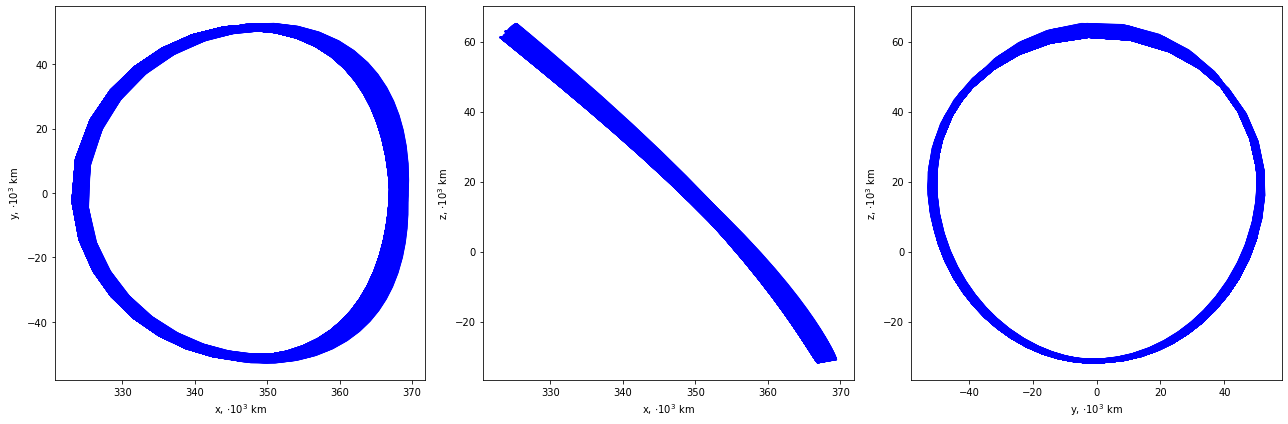

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
#v0 = v
beg = values[-1][0] + 1
for k in range(beg, beg + 180):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
            
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2
            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        
        v1, dist = opt.getXY()
        cur[4] = v1 

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    distance = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    vx = ev1.iloc[-1, 7]
    values.append((k, x1, z1, v1, distance, vx))
    arrs.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    print()
    plotter.plot_proj(arr1, ax=ax, lw=1);

In [17]:
values1 = np.array(values)

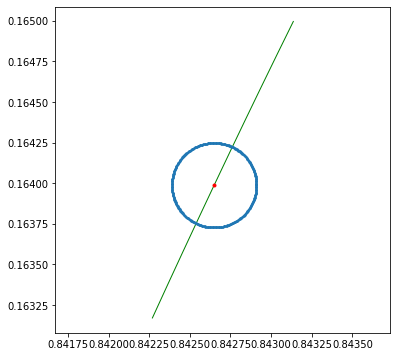

In [18]:
fig, ax = plt.subplots(figsize = (6,6))
ax.axis('equal')
#ax.plot(halo.x, halo.z, 'b')
ax.plot(halo.x[650:660], halo.z[650:660], 'g', lw=1)
ax.plot(x, z, '.r')
ax.plot(values1[:, 1], values1[:, 2], '.', ms=3)

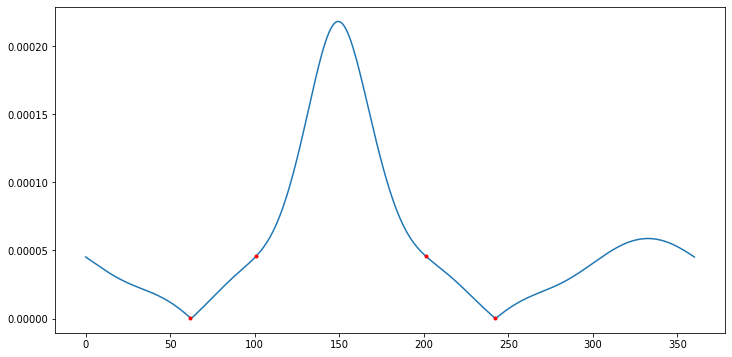

In [30]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(values1[:, 0], values1[:, -2], '-')
ax.plot(values1[[62, 101, 201, 242], 0], values1[[62, 101, 201, 242], -2], 'r.')

# Second step

In [31]:
x, z, v = values1[101, 1:4]
radius = 25 / model.R 
dalpha = np.pi / 180 

In [32]:
x, z, v

(0.8425999733334011, 0.16424333919872292, 0.26839894995656655)

In [33]:
values2 = []
arrs2 = []

0 [0.84266501 0.         0.16424334 0.         0.26839895 0.        ]
0 9.999999999998899e-05 j 8 dist 5.518895168594362e-09
1 9.165085357309977e-10 j 149 dist 7.0552758776316e-07
2 6.623220305534971e-10 j 11 dist 6.753233527370825e-08
3 1.0400014183176154e-11 j 10 dist 5.82658104074183e-10
4 6.480926906249351e-13 j 8 dist 1.2555661547327015e-07
5 3.214650767802141e-13 j 8 dist 2.650515531562599e-06
v 0.2663640959998722
Distance 2.503875412600486e-05
vx 7.086166775777895e-05


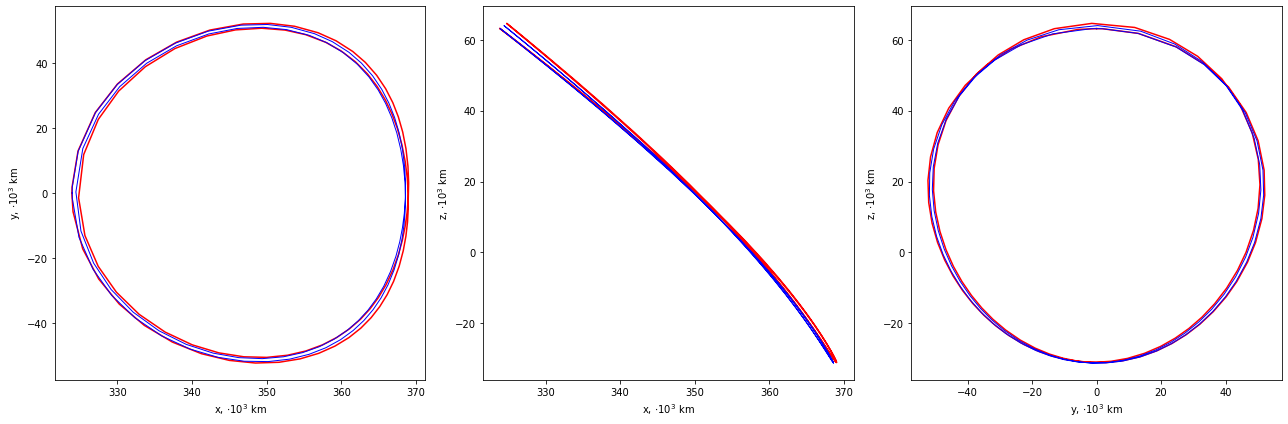

In [34]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')

beg = 0

for k in range(beg, beg + 1):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2
            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()   
        print(i, abs(v1 - cur[4]), 'j', j, 'dist', dist)
        cur[4] = v1
        
    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    distance = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    vx = ev1.iloc[-1, 7]
    values2.append((k, x1, z1, v1, distance, vx))
    arrs2.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr_ref, ax=ax, colors='r');
    plotter.plot_proj(arr1, ax=ax, lw=1);

181 [0.84253495 0.         0.1642422  0.         0.26839895 0.        ]
v 0.2710110335759973
Distance 0.00010111143953957908
vx 0.00019527901665268143

182 [0.84253498 0.         0.16424107 0.         0.26839895 0.        ]
v 0.27097894506778897
Distance 9.969488471823197e-05
vx 0.00019355187002276794

183 [0.84253503 0.         0.16423994 0.         0.26839895 0.        ]
v 0.2709461247082054
Distance 9.826287650577591e-05
vx 0.0001918013881165412

184 [0.8425351  0.         0.1642388  0.         0.26839895 0.        ]
v 0.27091259551287833
Distance 9.681725242742864e-05
vx 0.00019002966642745834

185 [0.84253518 0.         0.16423767 0.         0.26839895 0.        ]
v 0.2708783803859797
Distance 9.535981525666742e-05
vx 0.00018823867518855467

186 [0.84253529 0.         0.16423654 0.         0.26839895 0.        ]
v 0.2708435020929218
Distance 9.389232460363411e-05
vx 0.00018643051124297419

187 [0.84253542 0.         0.16423541 0.         0.26839895 0.        ]
v 0.2708079832363425

v 0.26872646309542714
Distance 3.3827814488913055e-05
vx 0.00010562956121835769

236 [0.84256361 0.         0.16418942 0.         0.26839895 0.        ]
v 0.26868165317177006
Distance 3.311291463736708e-05
vx 0.00010447399154177132

237 [0.84256455 0.         0.1641888  0.         0.26839895 0.        ]
v 0.2686369932176528
Distance 3.24227000427933e-05
vx 0.0001033430606281055

238 [0.84256551 0.         0.16418819 0.         0.26839895 0.        ]
v 0.26859249321786277
Distance 3.175716416303144e-05
vx 0.00010223668817182369

239 [0.84256648 0.         0.16418759 0.         0.26839895 0.        ]
v 0.2685481630014427
Distance 3.111628373366047e-05
vx 0.00010115477618670779

240 [0.84256746 0.         0.16418702 0.         0.26839895 0.        ]
v 0.2685040122451038
Distance 3.0500019027605862e-05
vx 0.00010009721301229915

241 [0.84256844 0.         0.16418646 0.         0.26839895 0.        ]
v 0.26846005047634813
Distance 2.99083083650972e-05
vx 9.90638605964031e-05

242 [0.8425694

v 0.26670231478625517
Distance 2.349040852794857e-05
vx 7.261216194103806e-05

291 [0.84262328 0.         0.16418262 0.         0.26839895 0.        ]
v 0.2666773083879943
Distance 2.359318928628012e-05
vx 7.242838249356642e-05

292 [0.84262434 0.         0.16418304 0.         0.26839895 0.        ]
v 0.2666528265506516
Distance 2.3696949015090394e-05
vx 7.225326313544615e-05

293 [0.84262539 0.         0.16418347 0.         0.26839895 0.        ]
v 0.2666288734033436
Distance 2.3801380734376956e-05
vx 7.208650689592577e-05

294 [0.84262643 0.         0.16418393 0.         0.26839895 0.        ]
v 0.2666054529886016
Distance 2.390619231151984e-05
vx 7.192782627922327e-05

295 [0.84262746 0.         0.1641844  0.         0.26839895 0.        ]
v 0.26658256926238666
Distance 2.40111066807825e-05
vx 7.177694178957857e-05

296 [0.84262848 0.         0.16418488 0.         0.26839895 0.        ]
v 0.26656022609413255
Distance 2.4115861382083993e-05
vx 7.163357693501949e-05

297 [0.8426295  0

v 0.26618445036442
Distance 2.6088711698785586e-05
vx 6.992143814991058e-05

346 [0.84266308 0.         0.16422761 0.         0.26839895 0.        ]
v 0.2661921217519157
Distance 2.6039854527025833e-05
vx 6.995752162568475e-05

347 [0.84266334 0.         0.16422871 0.         0.26839895 0.        ]
v 0.2662004131072562
Distance 2.598757678890421e-05
vx 6.999675431344776e-05

348 [0.84266359 0.         0.16422982 0.         0.26839895 0.        ]
v 0.2662093235772228
Distance 2.593194895631794e-05
vx 7.003925267755687e-05

349 [0.84266381 0.         0.16423093 0.         0.26839895 0.        ]
v 0.26621885221150693
Distance 2.5873054076177802e-05
vx 7.008516141294432e-05

350 [0.84266402 0.         0.16423205 0.         0.26839895 0.        ]
v 0.2662289979621228
Distance 2.5810973879198705e-05
vx 7.013461749147973e-05

351 [0.84266421 0.         0.16423317 0.         0.26839895 0.        ]
v 0.266239759683397
Distance 2.574580103878948e-05
vx 7.018777398879773e-05

352 [0.84266438 0.  

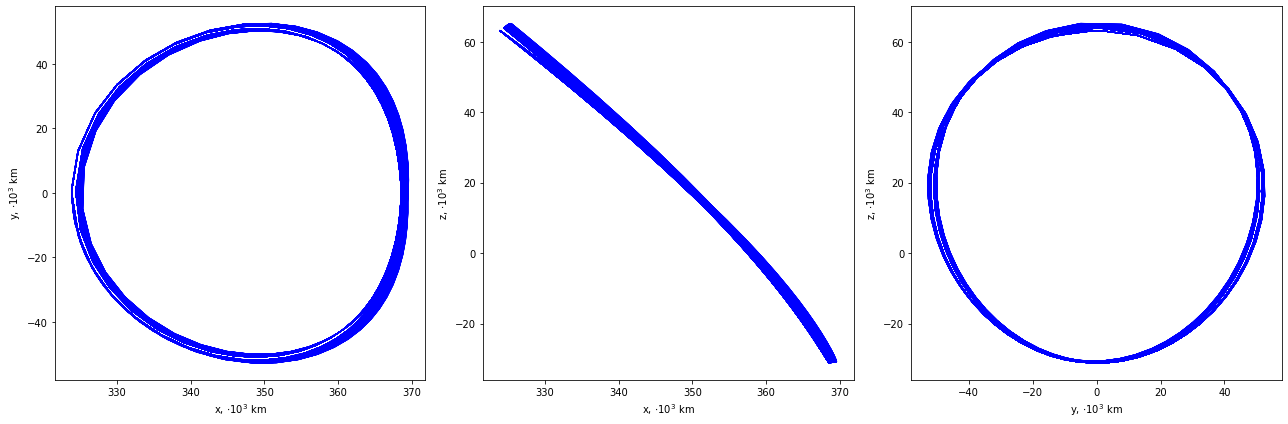

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
#v0 = v
beg = values2[-1][0] + 1
for k in range(beg, beg + 180):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
            
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2
            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        
        v1, dist = opt.getXY()
        cur[4] = v1
        

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    distance = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    vx = ev1.iloc[-1, 7]
    values2.append((k, x1, z1, v1, vx, distance))
    arrs2.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    print()
    plotter.plot_proj(arr1, ax=ax, lw=1);

In [37]:
values3 = np.array(values2)

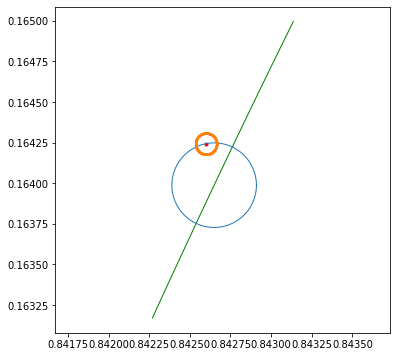

In [38]:
fig, ax = plt.subplots(figsize = (6,6))
ax.axis('equal')
ax.plot(halo.x[650:660], halo.z[650:660], 'g', lw=1)
ax.plot(x, z, '.r')
ax.plot(values1[:, 1], values1[:, 2], lw=1)
ax.plot(values3[:, 1], values3[:, 2], '.', ms=2)

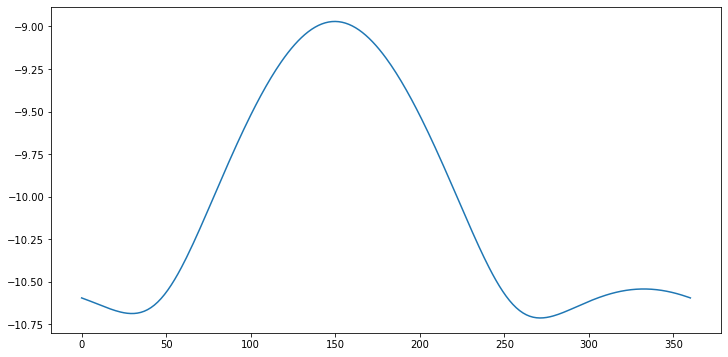

In [47]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(values3[:, 0], np.log(values3[:, -2]), '-')

2.284348835544909e-05
7.760041396022476e-05
0.26839894995656655


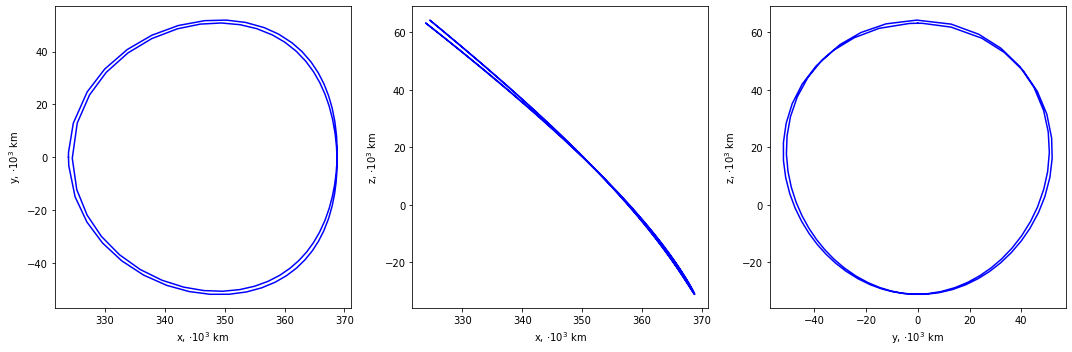

In [48]:
s = model.get_zero_state()
s[0], s[2], s[4] = values3[30, 1:4]
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(s, 0., 20.*np.pi, last_state='last')
plotter.plot_proj(arr);
print(np.linalg.norm(s[:3] - ev.iloc[-1, 4:7]))
print(ev.iloc[-1, 7])
print(v)

# Third step

In [736]:
x, z, v = values3[30, 1:4]
radius = 25 / model.R 
dalpha = np.pi / 180 

In [627]:
x, z, v

(0.8426406690839319, 0.1645002820552773, 0.2742282223062394)

2.2843439093307637e-05
7.760036475371653e-05
0.2671164318825609


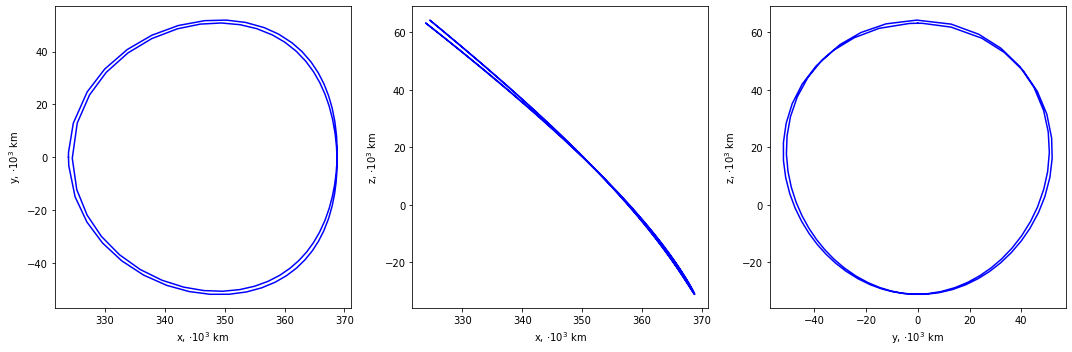

In [741]:
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
plotter.plot_proj(arr);
print(np.linalg.norm(ref[:3] - ev.iloc[-1, 4:7]))
print(ev.iloc[-1, 7])
print(v)

In [742]:
values4 = []
arrs4 = []

0 [0.84272133 0.         0.16427586 0.         0.26711643 0.        ]
0 5.370483502353807e-10 j 8 dist 5.356784698795326e-09
1 9.999999999732445e-07 j 12 dist 6.655503553574502e-07
2 1.6059126251022349e-10 j 11 dist 7.382207106735863e-08
3 1.080896483429683e-11 j 10 dist 1.6228455506021558e-10
4 1.8759999109718706e-10 j 8 dist 1.3501356866847405e-07
5 3.4477976029734236e-13 j 8 dist 2.1652017756043074e-06
v 0.26526175504019217
Distance 4.6558871747772856e-05
vx 1.9500378504176857e-05


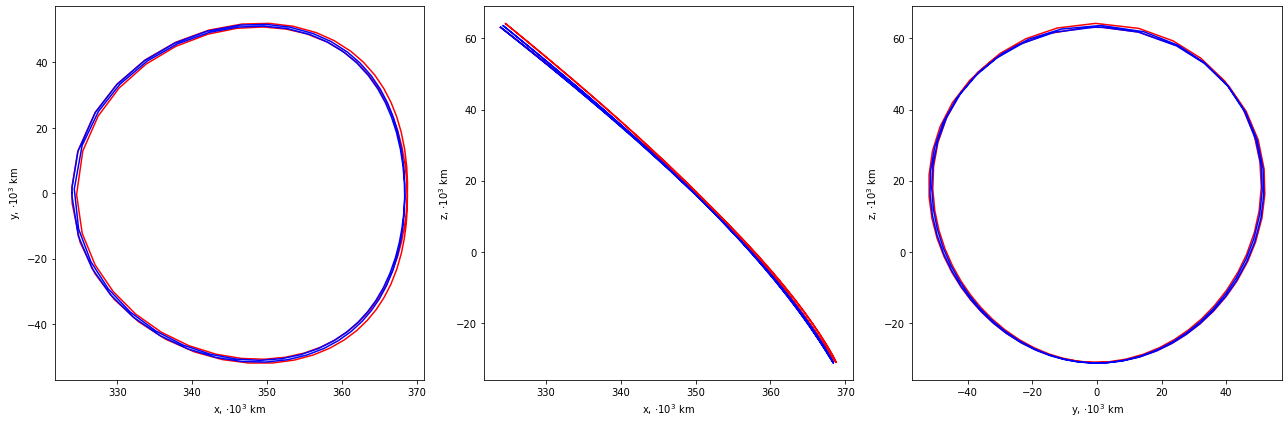

In [743]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
beg = 0
for k in range(beg, beg + 1):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()   
        print(i, abs(v1 - cur[4]), 'j', j, 'dist', dist)
        cur[4] = v1

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    vx = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    distance = ev1.iloc[-1, 7]
    values4.append((k, x1, z1, v1, distance, vx))
    arrs4.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr_ref, ax=ax, colors='red');    
    plotter.plot_proj(arr1, ax=ax);

183 [0.84259135 0.         0.16427245 0.         0.26711643 0.        ]
v 0.26927664791923117
Distance 9.850494212112343e-05
vx 4.272173259555513e-05
184 [0.84259142 0.         0.16427132 0.         0.26711643 0.        ]
v 0.2692506960839245
Distance 9.765661136901076e-05
vx 4.207931960215439e-05
185 [0.84259151 0.         0.16427019 0.         0.26711643 0.        ]
v 0.2692241193819905
Distance 9.6796850334889e-05
vx 4.14295294652077e-05
186 [0.84259162 0.         0.16426906 0.         0.26711643 0.        ]
v 0.2691969325470107
Distance 9.592686920008482e-05
vx 4.0773146769700605e-05
187 [0.84259174 0.         0.16426793 0.         0.26711643 0.        ]
v 0.2691691504027117
Distance 9.504742159703074e-05
vx 4.011091052443344e-05
188 [0.84259189 0.         0.16426681 0.         0.26711643 0.        ]
v 0.26914078786357554
Distance 9.415955389922674e-05
vx 3.9443574260818526e-05
189 [0.84259206 0.         0.16426568 0.         0.26711643 0.        ]
v 0.26911185991025804
Distance 9.

v 0.26730364826254077
Distance 5.52057937048241e-05
vx 1.2182979925802404e-05
239 [0.8426228  0.         0.16422011 0.         0.26711643 0.        ]
v 0.26726439413231623
Distance 5.473112912125896e-05
vx 1.1960804910562463e-05
240 [0.84262378 0.         0.16421953 0.         0.26711643 0.        ]
v 0.26722524389384134
Distance 5.430579850949262e-05
vx 1.176951059528656e-05
241 [0.84262477 0.         0.16421898 0.         0.26711643 0.        ]
v 0.267186205842337
Distance 5.382590915822523e-05
vx 1.1576038244963798e-05
242 [0.84262576 0.         0.16421843 0.         0.26711643 0.        ]
v 0.2671472914072222
Distance 5.339520180174494e-05
vx 1.1413773692364487e-05
243 [0.84262677 0.         0.16421791 0.         0.26711643 0.        ]
v 0.26710850972504124
Distance 5.2978971931058605e-05
vx 1.1271722866622947e-05
244 [0.84262779 0.         0.1642174  0.         0.26711643 0.        ]
v 0.26706987035096197
Distance 5.257704023781985e-05
vx 1.1149834669981398e-05
245 [0.84262881 0. 

v 0.265519460548964
Distance 4.616203298635647e-05
vx 1.7759366470671884e-05
294 [0.84268275 0.         0.16421644 0.         0.26711643 0.        ]
v 0.26549767847995864
Distance 4.619433203680674e-05
vx 1.793051982817108e-05
295 [0.84268378 0.         0.16421691 0.         0.26711643 0.        ]
v 0.265476383128762
Distance 4.6228611840279116e-05
vx 1.809832065292672e-05
296 [0.84268481 0.         0.1642174  0.         0.26711643 0.        ]
v 0.2654555786746824
Distance 4.6265006037379125e-05
vx 1.8262865749667427e-05
297 [0.84268582 0.         0.16421791 0.         0.26711643 0.        ]
v 0.26543526919474975
Distance 4.630311928762029e-05
vx 1.8423951449260215e-05
298 [0.84268683 0.         0.16421843 0.         0.26711643 0.        ]
v 0.26541545867513583
Distance 4.634293655232874e-05
vx 1.8581598452723128e-05
299 [0.84268783 0.         0.16421898 0.         0.26711643 0.        ]
v 0.2653961509986945
Distance 4.6383834770151976e-05
vx 1.8735479780382083e-05
300 [0.84268881 0.  

v 0.26512077443405346
Distance 4.7069053776051164e-05
vx 2.075644894879872e-05
349 [0.84272014 0.         0.16426345 0.         0.26711643 0.        ]
v 0.2651294124734626
Distance 4.703255903777898e-05
vx 2.0677061811788857e-05
350 [0.84272034 0.         0.16426456 0.         0.26711643 0.        ]
v 0.26513862125612425
Distance 4.699427416866679e-05
vx 2.0592799641120726e-05
351 [0.84272053 0.         0.16426568 0.         0.26711643 0.        ]
v 0.26514839945885216
Distance 4.695461479297357e-05
vx 2.0503864908499726e-05
352 [0.8427207  0.         0.16426681 0.         0.26711643 0.        ]
v 0.2651587456446707
Distance 4.691344388616913e-05
vx 2.041014510147294e-05
353 [0.84272085 0.         0.16426793 0.         0.26711643 0.        ]
v 0.26516965828227623
Distance 4.687170029437065e-05
vx 2.031214125759641e-05
354 [0.84272098 0.         0.16426906 0.         0.26711643 0.        ]
v 0.26518113570991425
Distance 4.682846323715052e-05
vx 2.0209287195719855e-05
355 [0.84272109 0. 

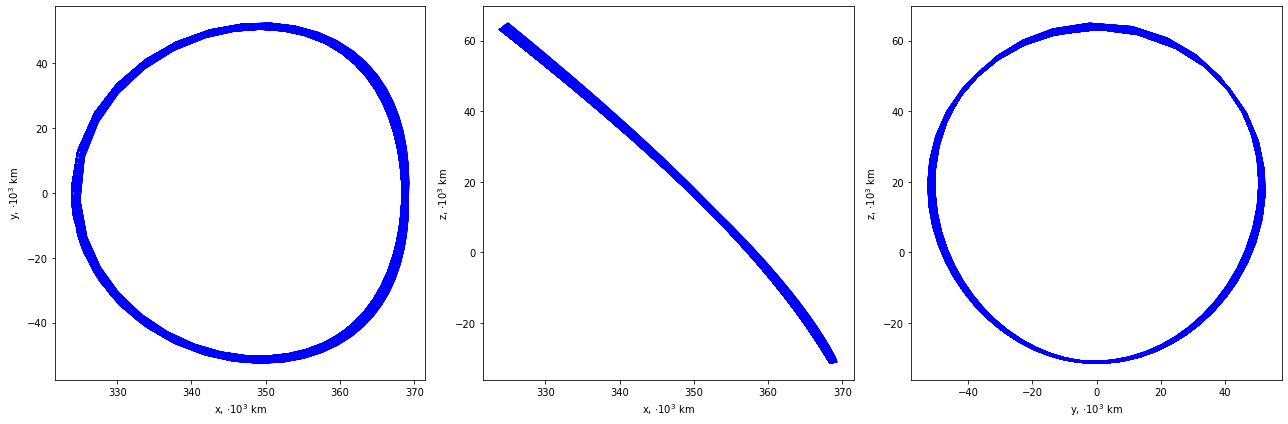

In [755]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
beg = values4[-1][0] + 1

for k in range(beg, beg + 180):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()
        cur[4] = v1

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    vx = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    distance = ev1.iloc[-1, 7]
    values4.append((k, x1, z1, v1, distance, vx))
    arrs4.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr1, ax=ax);

In [756]:
values5 = np.array(values4)

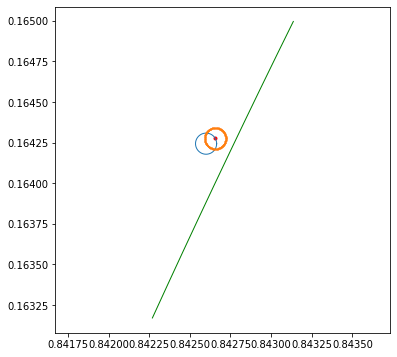

In [757]:
fig, ax = plt.subplots(figsize = (6,6))
ax.axis('equal')
ax.plot(halo.x[650:660], halo.z[650:660], 'g', lw=1)
ax.plot(x, z, '.r')
ax.plot(values3[:, 1], values3[:, 2], lw=1)
ax.plot(values5[:, 1], values5[:, 2], '.', ms=1)

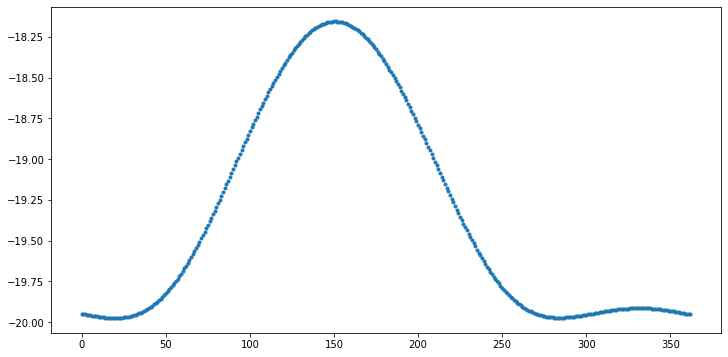

In [763]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(values5[:, 0], np.log(values5[:, -2]**2), '.')

1.1390015821765184e-05
5.0173388613667215e-05
0.2671164318825609


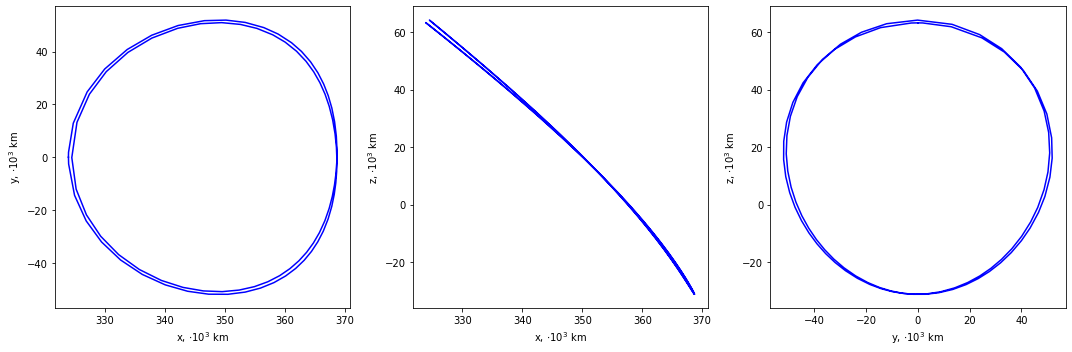

In [764]:
s = model.get_zero_state()
s[0], s[2], s[4] = values5[52, 1:4]
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(s, 0., 20.*np.pi, last_state='last')
plotter.plot_proj(arr);
print(np.linalg.norm(s[:3] - ev.iloc[-1, 4:7]))
print(ev.iloc[-1, 7])
print(v)

# Fourth step

In [765]:
x, z, v = values5[52, 1:4]
radius = 25 / model.R 
dalpha = np.pi / 180 

In [766]:
x, z, v

(0.8426963369441652, 0.1643271068075683, 0.2666980218910354)

1.1390015821765184e-05
5.0173388613667215e-05
0.2666980218910354


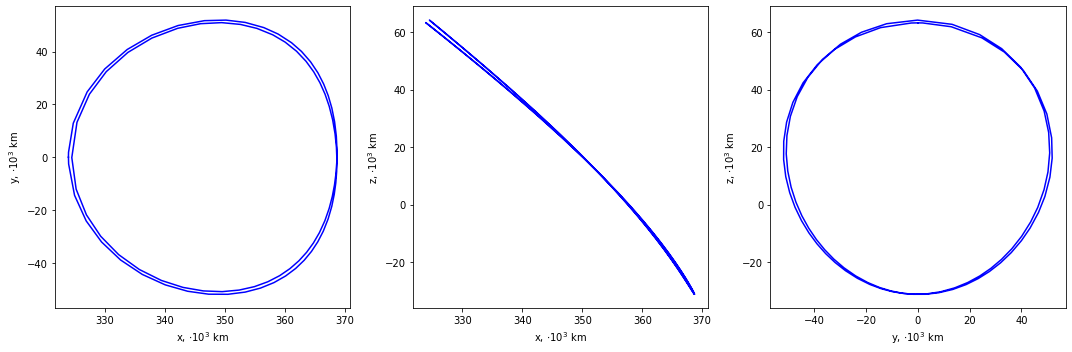

In [767]:
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
plotter.plot_proj(arr);
print(np.linalg.norm(ref[:3] - ev.iloc[-1, 4:7]))
print(ev.iloc[-1, 7])
print(v)

In [768]:
values6 = []
arrs6 = []

0 [0.84276137 0.         0.16432711 0.         0.26669802 0.        ]
0 3.803239945199266e-10 j 8 dist 5.314823543335827e-09
1 9.555978230935125e-11 j 19 dist 6.569962868051339e-07
2 9.999999999732445e-07 j 11 dist 7.634143994240379e-08
3 8.376632720796806e-14 j 9 dist 1.0844406811156283e-10
4 3.2940317140628395e-13 j 8 dist 1.3819167138790035e-07
5 4.953260024365136e-13 j 8 dist 2.073017212257094e-06
v 0.2648803129022287
Distance 4.118288919234547e-05
vx 1.8614448214028648e-05


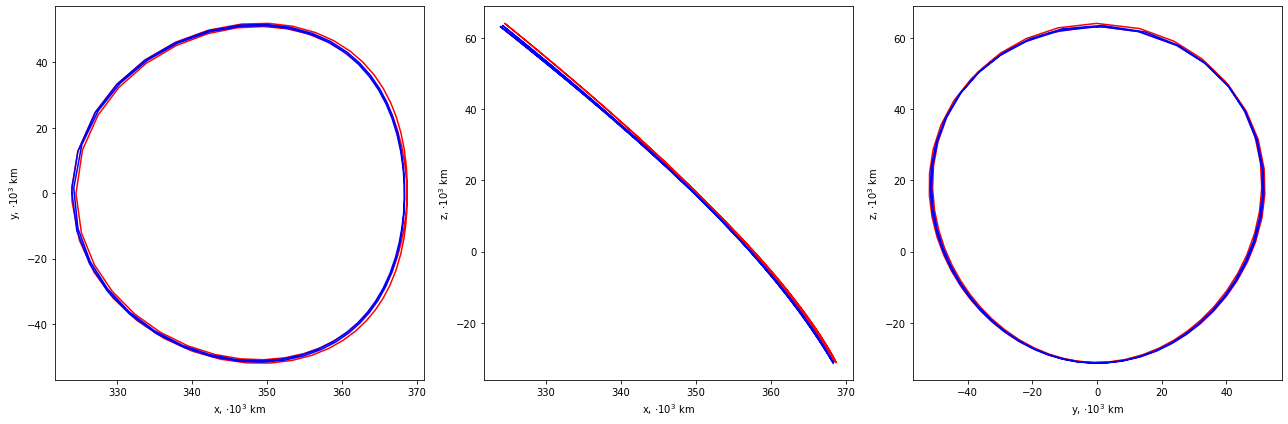

In [769]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
beg = 0
for k in range(beg, beg + 1):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()   
        print(i, abs(v1 - cur[4]), 'j', j, 'dist', dist)
        cur[4] = v1

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    vx = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    distance = ev1.iloc[-1, 7]
    values6.append((k, x1, z1, v1, distance, vx))
    arrs6.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr_ref, ax=ax, colors='red');    
    plotter.plot_proj(arr1, ax=ax);

181 [0.84263131 0.         0.16432597 0.         0.26669802 0.        ]
v 0.26883883436325434
Distance 7.984150987632756e-05
vx 3.469165458796356e-05
182 [0.84263134 0.         0.16432484 0.         0.26669802 0.        ]
v 0.2688153377318746
Distance 7.917345017999927e-05
vx 3.418643782591017e-05
183 [0.84263139 0.         0.1643237  0.         0.26669802 0.        ]
v 0.2687912046146896
Distance 7.849464535802236e-05
vx 3.367372032285206e-05
184 [0.84263146 0.         0.16432257 0.         0.26669802 0.        ]
v 0.2687664483146741
Distance 7.780592655047026e-05
vx 3.3154120090636886e-05
185 [0.84263155 0.         0.16432144 0.         0.26669802 0.        ]
v 0.268741082285438
Distance 7.71082082045172e-05
vx 3.262825127770523e-05
186 [0.84263166 0.         0.16432031 0.         0.26669802 0.        ]
v 0.2687151201086526
Distance 7.64021257971155e-05
vx 3.209671951172572e-05
187 [0.84263179 0.         0.16431918 0.         0.26669802 0.        ]
v 0.2686885754912543
Distance 7.568

v 0.26696174260265915
Distance 4.506788469876063e-05
vx 9.07489648652054e-06
237 [0.84266092 0.         0.16427256 0.         0.26669802 0.        ]
v 0.2669233175766484
Distance 4.470395345773041e-05
vx 8.884754137508019e-06
238 [0.84266187 0.         0.16427195 0.         0.26669802 0.        ]
v 0.26688496327290784
Distance 4.435313780536045e-05
vx 8.714810727901244e-06
239 [0.84266284 0.         0.16427136 0.         0.26669802 0.        ]
v 0.2668466898219503
Distance 4.4015467674045e-05
vx 8.565570717896175e-06
240 [0.84266382 0.         0.16427078 0.         0.26669802 0.        ]
v 0.2668085072362044
Distance 4.3690802134557e-05
vx 8.437439466650598e-06
241 [0.84266481 0.         0.16427022 0.         0.26669802 0.        ]
v 0.26677042541070645
Distance 4.337912874927564e-05
vx 8.330705084712605e-06
242 [0.8426658  0.         0.16426968 0.         0.26669802 0.        ]
v 0.26673245412328045
Distance 4.308029692886325e-05
vx 8.245513923262716e-06
243 [0.84266681 0.         0.1

v 0.26518104734917963
Distance 4.0209889821354004e-05
vx 1.643527201642409e-05
292 [0.8427207  0.         0.16426681 0.         0.26669802 0.        ]
v 0.2651586648213687
Distance 4.028873989588575e-05
vx 1.662199128671814e-05
293 [0.84272175 0.         0.16426724 0.         0.26669802 0.        ]
v 0.26513675004177667
Distance 4.0368814595511966e-05
vx 1.6805177619914713e-05
294 [0.84272279 0.         0.16426769 0.         0.26669802 0.        ]
v 0.2651153074228127
Distance 4.0449889676637176e-05
vx 1.6984737919167535e-05
295 [0.84272382 0.         0.16426816 0.         0.26669802 0.        ]
v 0.26509434128027876
Distance 4.053174743242488e-05
vx 1.7160585685595632e-05
296 [0.84272485 0.         0.16426865 0.         0.26669802 0.        ]
v 0.26507385583332393
Distance 4.061416973942674e-05
vx 1.7332636827068644e-05
297 [0.84272586 0.         0.16426916 0.         0.26669802 0.        ]
v 0.26505385520247476
Distance 4.069677020779208e-05
vx 1.750071934747818e-05
298 [0.84272687 0

v 0.2647270609582466
Distance 4.214479829037568e-05
vx 2.0060715290448103e-05
347 [0.84275971 0.         0.16431248 0.         0.26669802 0.        ]
v 0.2647343824930216
Distance 4.209244909535517e-05
vx 1.9988760897486842e-05
348 [0.84275995 0.         0.16431358 0.         0.26669802 0.        ]
v 0.2647422674682929
Distance 4.203710863537671e-05
vx 1.9911867884020004e-05
349 [0.84276018 0.         0.1643147  0.         0.26669802 0.        ]
v 0.26475071474610073
Distance 4.197887185373658e-05
vx 1.983006032838046e-05
350 [0.84276039 0.         0.16431581 0.         0.26669802 0.        ]
v 0.26475972308076334
Distance 4.191784599532483e-05
vx 1.9743362411625836e-05
351 [0.84276057 0.         0.16431693 0.         0.26669802 0.        ]
v 0.2647692911186593
Distance 4.185415622465216e-05
vx 1.965180125700446e-05
352 [0.84276074 0.         0.16431806 0.         0.26669802 0.        ]
v 0.26477941739783234
Distance 4.178791013862565e-05
vx 1.9555405373099463e-05
353 [0.84276089 0.   

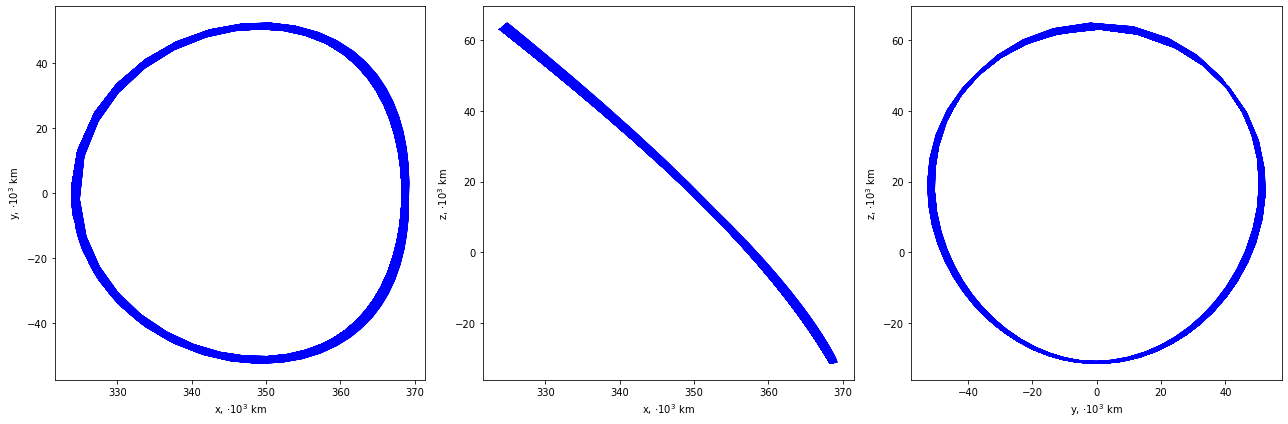

In [774]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
beg = values6[-1][0] + 1

for k in range(beg, beg + 180):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()
        cur[4] = v1

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    vx = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    distance = ev1.iloc[-1, 7]
    values6.append((k, x1, z1, v1, distance, vx))
    arrs6.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr1, ax=ax);

In [799]:
values7 = np.array(values6)

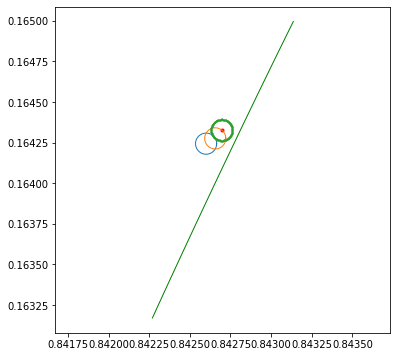

In [776]:
fig, ax = plt.subplots(figsize = (6,6))
ax.axis('equal')
ax.plot(halo.x[650:660], halo.z[650:660], 'g', lw=1)
ax.plot(x, z, '.r')
ax.plot(values3[:, 1], values3[:, 2], lw=1)
ax.plot(values5[:, 1], values5[:, 2], lw=1)
ax.plot(values7[:, 1], values7[:, 2], '.', ms=1)

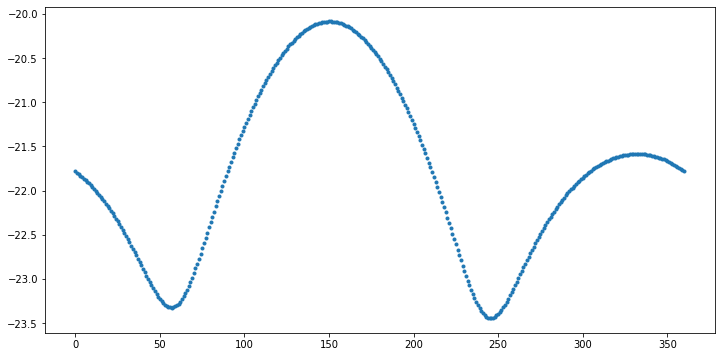

In [784]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(values7[:, 0], np.log(values7[:, -1]**2), '.')

# Fifth step

In [788]:
x, z, v = values7[57, 1:4]
radius = 25 / model.R 
dalpha = np.pi / 180 

In [789]:
x, z, v

(0.8427317583174102, 0.16438165093919846, 0.2664726945094122)

8.612530870912737e-06
4.190950054660516e-05
0.2664726945094122


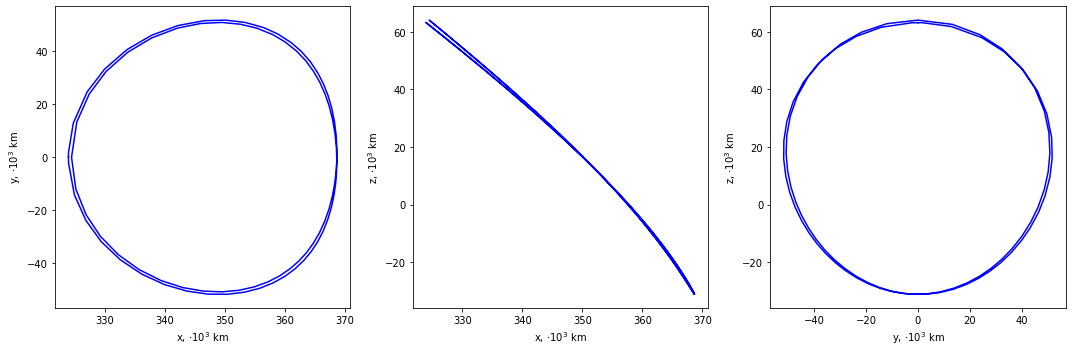

In [790]:
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
det_y = op.event_detector(model, events=[op.eventY(count=4)])
arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
plotter.plot_proj(arr);
print(np.linalg.norm(ref[:3] - ev.iloc[-1, 4:7]))
print(ev.iloc[-1, 7])
print(v)

In [791]:
values8 = []
arrs8 = []

0 [0.84279679 0.         0.16438165 0.         0.26647269 0.        ]
0 1.1589739723483206e-09 j 8 dist 5.298880763720051e-09
1 9.999999999732445e-07 j 149 dist 6.549837622222048e-07
2 1.034332064442367e-10 j 10 dist 7.80302225017094e-08
3 1.1074474670635936e-13 j 9 dist 9.116564169425249e-11
4 3.321676267376006e-12 j 8 dist 1.4104103972528092e-07
5 6.781797345922769e-13 j 8 dist 2.049163080475661e-06
v 0.2646645932042917
Distance 3.8923673322005525e-05
vx 1.8367990086943287e-05


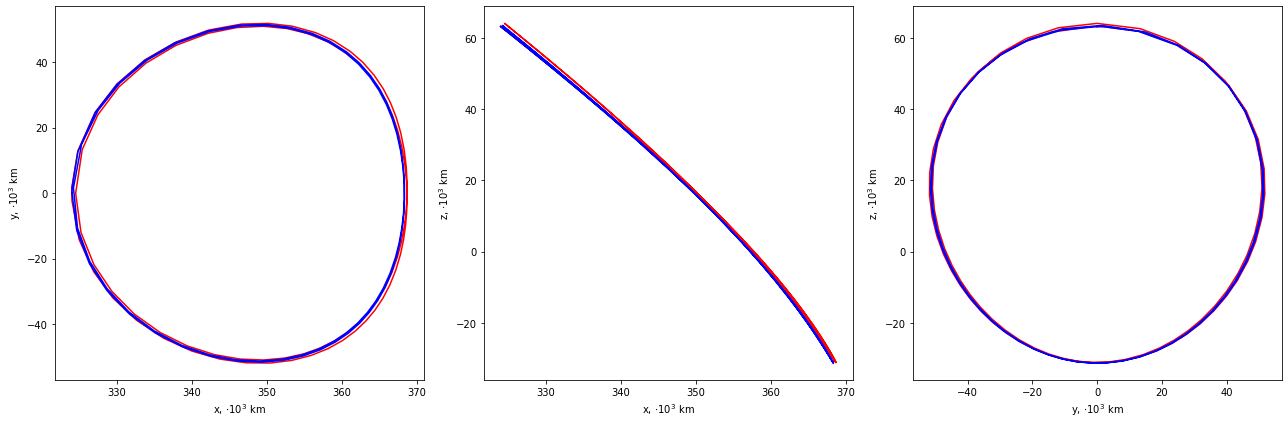

In [792]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
beg = 0
for k in range(beg, beg + 1):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()   
        print(i, abs(v1 - cur[4]), 'j', j, 'dist', dist)
        cur[4] = v1

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    vx = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    distance = ev1.iloc[-1, 7]
    values8.append((k, x1, z1, v1, distance, vx))
    arrs8.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr_ref, ax=ax, colors='red');    
    plotter.plot_proj(arr1, ax=ax);

181 [0.84266673 0.         0.16438052 0.         0.26647269 0.        ]
v 0.2685958932602609
Distance 7.144227447003493e-05
vx 3.1609811974741874e-05
182 [0.84266676 0.         0.16437938 0.         0.26647269 0.        ]
v 0.26857269212759155
Distance 7.083046195175725e-05
vx 3.1144059318796794e-05
183 [0.84266681 0.         0.16437825 0.         0.26647269 0.        ]
v 0.26854885900527803
Distance 7.020897731760747e-05
vx 3.0671298024725326e-05
184 [0.84266688 0.         0.16437711 0.         0.26647269 0.        ]
v 0.2685244069081263
Distance 6.957859678983352e-05
vx 3.0192092304699554e-05
185 [0.84266697 0.         0.16437598 0.         0.26647269 0.        ]
v 0.26849934900227185
Distance 6.894005308968713e-05
vx 2.9707002964983983e-05
186 [0.84266708 0.         0.16437485 0.         0.26647269 0.        ]
v 0.26847369859579173
Distance 6.829430161587463e-05
vx 2.9216578934028937e-05
187 [0.84266721 0.         0.16437372 0.         0.26647269 0.        ]
v 0.2684474691124206
Dis

v 0.2667360310336108
Distance 4.025857794955588e-05
vx 7.789850750399271e-06
237 [0.84269634 0.         0.16432711 0.         0.26647269 0.        ]
v 0.26669786676396356
Distance 3.9953839044023836e-05
vx 7.622352466272475e-06
238 [0.84269729 0.         0.1643265  0.         0.26647269 0.        ]
v 0.26665977005545094
Distance 3.966172845823457e-05
vx 7.476165408607819e-06
239 [0.84269826 0.         0.1643259  0.         0.26647269 0.        ]
v 0.2666217510231303
Distance 3.9382129190432356e-05
vx 7.351914067558319e-06
240 [0.84269924 0.         0.16432533 0.         0.26647269 0.        ]
v 0.2665838196660528
Distance 3.911501379802126e-05
vx 7.250082729039125e-06
241 [0.84270023 0.         0.16432477 0.         0.26647269 0.        ]
v 0.2665459858676417
Distance 3.886025799814622e-05
vx 7.170986553408256e-06
242 [0.84270123 0.         0.16432423 0.         0.26647269 0.        ]
v 0.2665082599836083
Distance 3.86575202052955e-05
vx 7.12860511709249e-06
243 [0.84270223 0.         

v 0.26496500437719434
Distance 3.772120490302261e-05
vx 1.6155729030953563e-05
292 [0.84275612 0.         0.16432135 0.         0.26647269 0.        ]
v 0.26494271441236816
Distance 3.7824097838180804e-05
vx 1.6346099017244432e-05
293 [0.84275717 0.         0.16432178 0.         0.26647269 0.        ]
v 0.26492088946093884
Distance 3.792759080501612e-05
vx 1.653274966884351e-05
294 [0.84275821 0.         0.16432224 0.         0.26647269 0.        ]
v 0.2648995339452169
Distance 3.803132297555342e-05
vx 1.6715520429153438e-05
295 [0.84275924 0.         0.16432271 0.         0.26647269 0.        ]
v 0.26487865219703577
Distance 3.813547022085001e-05
vx 1.6894559352385652e-05
296 [0.84276027 0.         0.1643232  0.         0.26647269 0.        ]
v 0.2648582484418412
Distance 3.823941806464781e-05
vx 1.706956603627252e-05
297 [0.84276128 0.         0.1643237  0.         0.26647269 0.        ]
v 0.26483832681443525
Distance 3.8343095797015864e-05
vx 1.7240543438058748e-05
298 [0.84276229 0

v 0.2645122528548413
Distance 4.007169544979414e-05
vx 1.9833432051129073e-05
347 [0.84279513 0.         0.16436702 0.         0.26647269 0.        ]
v 0.26451952599509404
Distance 4.001005256901863e-05
vx 1.976064652422059e-05
348 [0.84279537 0.         0.16436813 0.         0.26647269 0.        ]
v 0.2645273600289145
Distance 3.994480429159175e-05
vx 1.9682852812468836e-05
349 [0.8427956  0.         0.16436924 0.         0.26647269 0.        ]
v 0.26453575381281963
Distance 3.9876052614282176e-05
vx 1.9600071112322213e-05
350 [0.84279581 0.         0.16437036 0.         0.26647269 0.        ]
v 0.26454470609534353
Distance 3.980390324930666e-05
vx 1.951232415187061e-05
351 [0.84279599 0.         0.16437148 0.         0.26647269 0.        ]
v 0.26455421551669966
Distance 3.9728464956374776e-05
vx 1.9419633888288486e-05
352 [0.84279616 0.         0.1643726  0.         0.26647269 0.        ]
v 0.2645642806086151
Distance 3.964987185505961e-05
vx 1.932202938112454e-05
353 [0.84279631 0. 

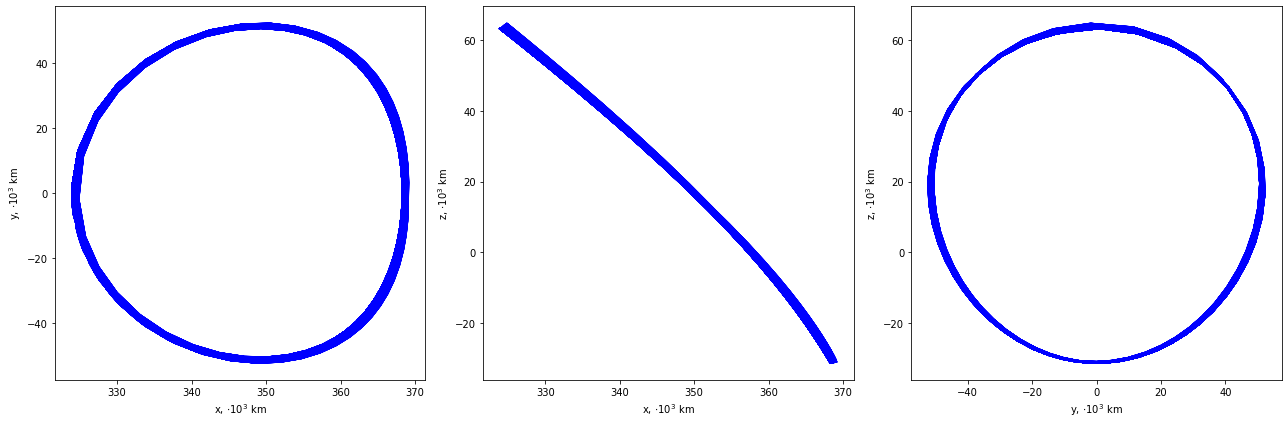

In [806]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])
ref = model.get_zero_state()
ref[0], ref[2], ref[4] = x, z, v
arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
beg = values8[-1][0] + 1

for k in range(beg, beg + 180):
    x1 = x + radius * np.cos(dalpha * (k))
    z1 = z + radius * np.sin(dalpha * (k))
    v1 = v

    cur = model.get_zero_state()
    cur[0], cur[2], cur[4] = x1, z1, v1
    print(k, cur)
    
    for i in range(6):  
        
        opt = optimizer()
        opt.dx = 1e-4
        opt.dxmax = 1
        opt.tolerance = 1e-10

        if i > 0:
            opt.dx = 1e-6
            opt.dxmax = 1e-2
    
        for j in range(150):
            if opt.needNextStep() == False: break

            det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
            arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
            dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

            v1 = opt.nextX(v1, dist)
            cur[4] = v1
        v1, dist = opt.getXY()
        cur[4] = v1

    print('v', v1)
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
    vx = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
    distance = ev1.iloc[-1, 7]
    values8.append((k, x1, z1, v1, distance, vx))
    arrs8.append(arr1)
    print("Distance", distance)
    print("vx", vx)
    plotter.plot_proj(arr1, ax=ax);

In [807]:
values9 = np.array(values8)

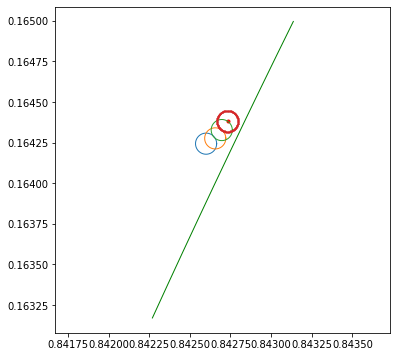

In [808]:
fig, ax = plt.subplots(figsize = (6,6))
ax.axis('equal')
ax.plot(halo.x[650:660], halo.z[650:660], 'g', lw=1)
ax.plot(x, z, '.r')
ax.plot(values3[:, 1], values3[:, 2], lw=1)
ax.plot(values5[:, 1], values5[:, 2], lw=1)
ax.plot(values7[:, 1], values7[:, 2], lw=1)
ax.plot(values9[:, 1], values9[:, 2], '.', ms=1)

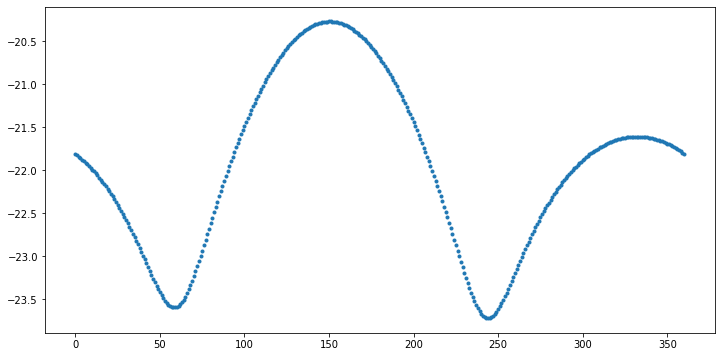

In [815]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(values9[:, 0], np.log(values9[:, -1]**2), '.')

## Several steps

In [838]:
x, z, v, d, vx = values9[59, 1:]
radius = 25 / model.R 
dalpha = np.pi / 180 
arrvs = []
vs = []

vals = []
arrvals = []

In [839]:
x, z, v

(0.8427652545501697, 0.16443739803211613, 0.26632324269927443)

In [840]:
vals.append((-1, x, z, v, d))

ref 0 [0.84324314 0.         0.16528782 0.         0.26504514 0.        ]
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 Distance 4.90476248286423e-06
ref 1 [0.84327467 0.         0.1653447  0.         0.26497519 0.        ]
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 Distance 4.726332367094206e-06
ref 2 [0.8433062  0.         0.16540158 0.         0.26490562 0.        ]
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 Distance 4.52931139381627e-06


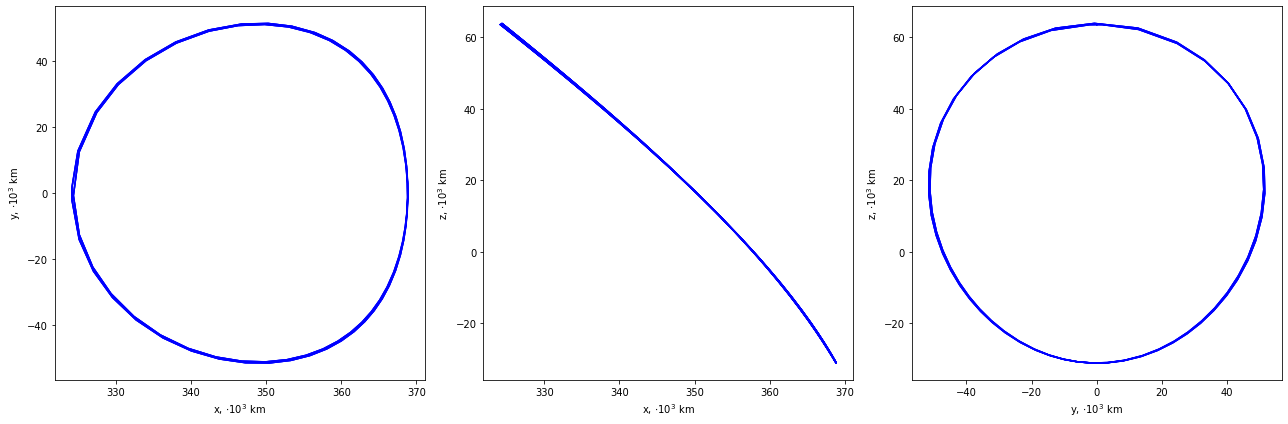

In [865]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
det_y = op.event_detector(model, events=[op.eventY(count=4)])

ind, x, z, v, d = vals[-1]

for n in range(3):
    ref = model.get_zero_state()
    ref[0], ref[2], ref[4] = x, z, v
    arr_ref, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last')
    print('ref', n, ref)
    
    for k in range(180):
        if k % 10 == 0:
            print(k, end=' ')


        x1 = x + radius * np.cos(dalpha * (k))
        z1 = z + radius * np.sin(dalpha * (k))
        v1 = v

        cur = model.get_zero_state()
        cur[0], cur[2], cur[4] = x1, z1, v1
        #print(k, cur)

        for i in range(6):  

            opt = optimizer()
            opt.dx = 1e-4
            opt.dxmax = 1
            opt.tolerance = 1e-10

            if i > 0:
                opt.dx = 1e-6
                opt.dxmax = 1e-2

            for j in range(150):
                if opt.needNextStep() == False: break

                det_yi = op.event_detector(model, events=[op.eventY(count=i+1)])
                arr, ev1 = det_yi.prop(cur, 0., 20.*np.pi, last_state='last')
                dist = np.linalg.norm(ev1.iloc[-1, 4:7] - ev.iloc[i%4, 4:7])**2

                v1 = opt.nextX(v1, dist)
                cur[4] = v1
            v1, dist = opt.getXY()
            cur[4] = v1

        #print('v', v1)
        det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
        arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
        distance = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])
        #vx = ev1.iloc[-1, 7]
        vs.append((k, x1, z1, v1, distance))
        arrvs.append(arr1)
        #print("Distance", distance)
        #print("vx", vx)
        #plotter.plot_proj(arr1, ax=ax);
        
    vs = np.array(vs)   
    m = min(vs[:, -1])
    ind, x, z, v, d = vs[vs[:, -1] == m][0]
    vals.append((n, x, z, v, d))
    print("Distance", d)
    
    plotter.plot_proj(arrvs[int(ind)], ax=ax);
    
    vs=[]
    arrvs=[]

In [861]:
vals1 = np.array(vals)
np.savetxt("2p_hw.txt", vals1)

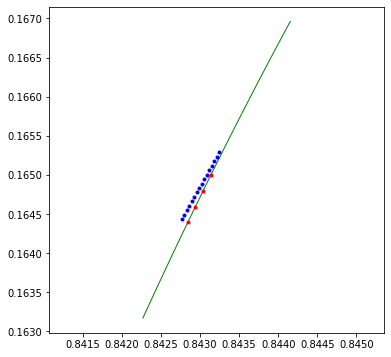

In [862]:
fig, ax = plt.subplots(figsize = (6,6))
ax.axis('equal')
ax.plot(halo.x[640:660], halo.z[640:660], 'g', lw=1)
ax.plot(halo.x[650:654], halo.z[650:654], '.r', lw=1)
ax.plot(vals1[:, 1], vals1[:, 2], 'b.')

In [863]:
vals1[-1]

array([2.00000000e+00, 8.43243139e-01, 1.65287818e-01, 2.65045138e-01,
       5.06513520e-06])

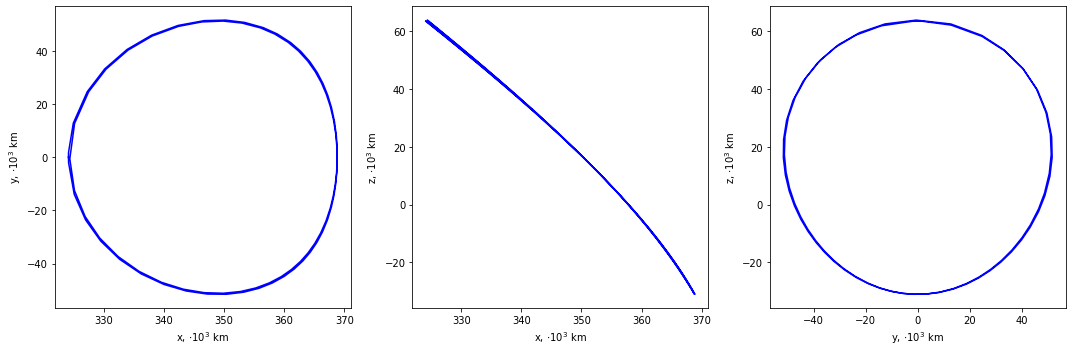

In [864]:
det_y = op.event_detector(model, events=[op.eventY(count=4)])
s = model.get_zero_state()
s[0], s[2], s[4] = vals1[-1, 1:4]

arr, ev = det_y.prop(s, 0., 20.*np.pi, last_state='last')
plotter.plot_proj(arr);